In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy import stats
from datetime import datetime, timedelta
from matplotlib.axes import Axes
import xesmf as xe
from scipy.interpolate import RegularGridInterpolator
from scipy import interpolate

/home/manmeet/anaconda3/envs/py35/lib/python3.7/site-packages/xarray/core/merge.py:16: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [3]:
data_dir = 'ocean_density.res.nc'  # daily
ds_density_i = xr.open_dataset(data_dir)

data_dir = 'ocean_temp_salt.res.nc'  # daily
ds_temp_salt = xr.open_dataset(data_dir)

data_dir = 'grid_spec.nc'  # daily
ds_grid_spec_720x410 = xr.open_dataset(data_dir)

data_dir = 'grid_spec_192_94_360_200.nc'  # daily
ds_grid_spec_360x200 = xr.open_dataset(data_dir)

In [5]:
ds_density_i

<xarray.Dataset>
Dimensions:            (Time: 1, xaxis_1: 360, yaxis_1: 200, zaxis_1: 50)
Coordinates:
  * xaxis_1            (xaxis_1) float64 1.0 2.0 3.0 4.0 ... 358.0 359.0 360.0
  * yaxis_1            (yaxis_1) float64 1.0 2.0 3.0 4.0 ... 198.0 199.0 200.0
  * zaxis_1            (zaxis_1) float64 1.0 2.0 3.0 4.0 ... 47.0 48.0 49.0 50.0
  * Time               (Time) float64 1.0
Data variables:
    rho                (Time, zaxis_1, yaxis_1, xaxis_1) float64 ...
    pressure_at_depth  (Time, zaxis_1, yaxis_1, xaxis_1) float64 ...
    denominator_r      (Time, zaxis_1, yaxis_1, xaxis_1) float64 ...
    drhodT             (Time, zaxis_1, yaxis_1, xaxis_1) float64 ...
    drhodS             (Time, zaxis_1, yaxis_1, xaxis_1) float64 ...
    drhodz_zt          (Time, zaxis_1, yaxis_1, xaxis_1) float64 ...
Attributes:
    filename:  RESTART/20141001.000000.ocean_density.res.nc

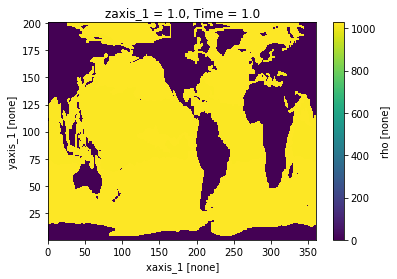

In [8]:
ds_density_i.rho.isel(zaxis_1=0).plot()

In [10]:
ds_density_i['xaxis_1'] = ds_grid_spec_360x200.gridlon_t.values
ds_density_i['yaxis_1'] = ds_grid_spec_360x200.gridlat_t.values
ds_density_i['zaxis_1'] = ds_grid_spec_360x200.zt.values

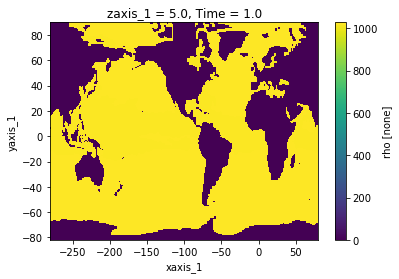

In [12]:
ds_density_i.rho.isel(zaxis_1=0).plot()

In [13]:
zt = ds_grid_spec_360x200.zt.values
zt1 = np.zeros((zt.shape[0]+1))
zt1[0] = zt[0]/2
zt1[-1] = zt[-1] + ((zt[-1] - zt[-2])/2)
for i in range(1,zt1.shape[0]-1):
    zt1[i] = (zt[i] + zt[i-1])/2

In [14]:
ds_out = xr.Dataset({'lat': (['lat'], ds_grid_spec_720x410.grid_y_T.values),
                     'lon': (['lon'], ds_grid_spec_720x410.grid_x_T.values),
                     'lev': (['lev'], ds_grid_spec_720x410.zt.values),
                    }
                   )
ds_density_i_ = ds_density_i.rename({
  "yaxis_1": "lat",
  "xaxis_1": "lon",
  "zaxis_1": "lev"
})

In [16]:
regridder = xe.Regridder(ds_density_i_, ds_out, 'bilinear')

Create weight file: bilinear_200x360_410x720.nc


In [17]:
regridder.clean_weight_file()

Remove file bilinear_200x360_410x720.nc


In [18]:
ds_density_o = regridder(ds_density_i_)

using dimensions ('lat', 'lon') from data variable rho as the horizontal dimensions for this dataset.


/home/manmeet/anaconda3/envs/py35/lib/python3.7/site-packages/xarray/core/dataarray.py:218: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif isinstance(data, pd.Panel):


In [20]:
def vinterp(field, levold, levnew):
    coords =  {'lat': field.lat.values, 'lon': field.lon.values, 'lev': levnew, 'Time': field.Time.values}
    dummy = np.zeros((field.Time.values.shape[0], levnew.shape[0], field.lat.values.shape[0], field.lon.values.shape[0]))
    field_o_ = xr.DataArray(data=dummy, coords=coords, dims=['Time', 'lev', 'lat', 'lon'])
    field_o = xr.Dataset(data_vars={"dummy": field_o_})
    for ii in field.data_vars:
        print(field[ii].name)
        if (len(field[ii].shape)==3):
            field_o[ii] = (('Time', 'lat', 'lon'),  field[ii].values)
        else:
            orig   = np.zeros((levold.shape[0], field[ii].shape[2], field[ii].shape[3]))
            interp = np.zeros((levnew.shape[0], field[ii].shape[2], field[ii].shape[3]))
            orig = field[ii].values[0,:,:,:]
            for i in range(field[ii].shape[2]):
                for j in range(field[ii].shape[3]):
                    f = interpolate.interp1d(levold, orig[:,i,j])
                    interp[:,i,j] = f(levnew)
            interp = np.expand_dims(interp, axis=0)
            field_o[ii] = (('Time', 'lev','lat', 'lon'),  interp)
    field_o = field_o.drop('dummy')
    return field_o

In [21]:
ds_density_o_ = vinterp(ds_density_o, ds_grid_spec_360x200.zt.values, ds_grid_spec_720x410.zt.values)

rho
pressure_at_depth
denominator_r
drhodT
drhodS
drhodz_zt


In [22]:
ds_density_o = ds_density_o_.rename({
  "lat": "yaxis_1",
  "lon": "xaxis_1",
  "lev": "zaxis_1",
})

In [24]:
x = ds_density_o.xaxis_1.values
ds_density_o['xaxis_1'] = np.arange(x.shape[0], dtype=np.double)

y = ds_density_o.yaxis_1.values
ds_density_o['yaxis_1'] = np.arange(y.shape[0], dtype=np.double)

z = ds_density_o.zaxis_1.values
ds_density_o['zaxis_1'] = np.arange(z.shape[0], dtype=np.double)

ds_density_o.xaxis_1.attrs['long_name'] = 'xaxis_1'
ds_density_o.xaxis_1.attrs['units'] = 'xaxis_1'
ds_density_o.xaxis_1.attrs['cartesian_axis'] = 'X'

ds_density_o.yaxis_1.attrs['long_name'] = 'yaxis_1'
ds_density_o.yaxis_1.attrs['units'] = 'yaxis_1'
ds_density_o.yaxis_1.attrs['cartesian_axis'] = 'Y'

ds_density_o.zaxis_1.attrs['long_name'] = 'zaxis_1'
ds_density_o.zaxis_1.attrs['units'] = 'zaxis_1'
ds_density_o.zaxis_1.attrs['cartesian_axis'] = 'Z'

ds_density_o.rho.attrs['long_name'] = 'rho'
ds_density_o.rho.attrs['units'] = 'none'

ds_density_o.pressure_at_depth.attrs['long_name'] = 'pressure_at_depth'
ds_density_o.pressure_at_depth.attrs['units'] = 'none'

ds_density_o.denominator_r.attrs['long_name'] = 'denominator_r'
ds_density_o.denominator_r.attrs['units'] = 'none'

ds_density_o.drhodT.attrs['long_name'] = 'drhodT'
ds_density_o.drhodT.attrs['units'] = 'none'

ds_density_o.drhodS.attrs['long_name'] = 'drhodS'
ds_density_o.drhodS.attrs['units'] = 'none'

ds_density_o.drhodz_zt.attrs['long_name'] = 'drhodz_zt'
ds_density_o.drhodz_zt.attrs['units'] = 'none'


In [25]:
ds_density_o.to_netcdf('ocean_density.res.regrid.nc')